In [188]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import data_utils
importlib.reload(data_utils)
import data_pipeline
importlib.reload(data_pipeline)
from data_pipeline import DataPipeline
import draw_utils
importlib.reload(draw_utils)
import linreg_utils
importlib.reload(linreg_utils)

<module 'linreg_utils' from 'c:\\Users\\BinaryCat17\\Documents\\Projects\\innopolis_course\\linreg_utils.py'>

### Генерация данных

In [189]:
pipe = DataPipeline('generate_data')
pipe.generate('X', data_utils.gen_range, beg='_beg', end='_end', interval='_interval', std_noise='_stdx')
pipe.transform('X', 'Y_true', data_utils.transform_feature, func='_func')
pipe.transform('Y_true', 'Y', data_utils.std_noise, std='_stdy')

data = [
    pipe.copy('linear').process(_func=lambda x: x, _beg=-100, _end=100, _interval=10, _stdx=2.5, _stdy=15),
    pipe.copy('power').process(_func=lambda x: x*x + 3 * x + 6, _beg=-10, _end=10, _interval=0.5, _stdx=0.5, _stdy=15),
    pipe.copy('log').process(_func=np.log, _beg=0.001, _end=5, _interval=0.3, _stdx=0.0, _stdy=0.4),
    pipe.copy('sin').process(_func=np.sin, _beg=0, _end=np.pi * 6, _interval=0.4, _stdx=0.0, _stdy=0.1),
]

### Визуализация данных

In [190]:
def draw_data(stats=[]):
    def do_draw_data(ax, p):
        ax.plot(p.val('X'), p.val('Y_true'), 'r--', label='Y_true')
        ax.scatter(p.val('X'), p.val('Y'), label='Y')
        if p.has('Y_pred'):
            ax.plot(p.val('X'), p.val('Y_pred'), 'g', label='Y_pred')
        if len(stats):
            draw_utils.draw_stats(ax, p, stats)
        
    return do_draw_data

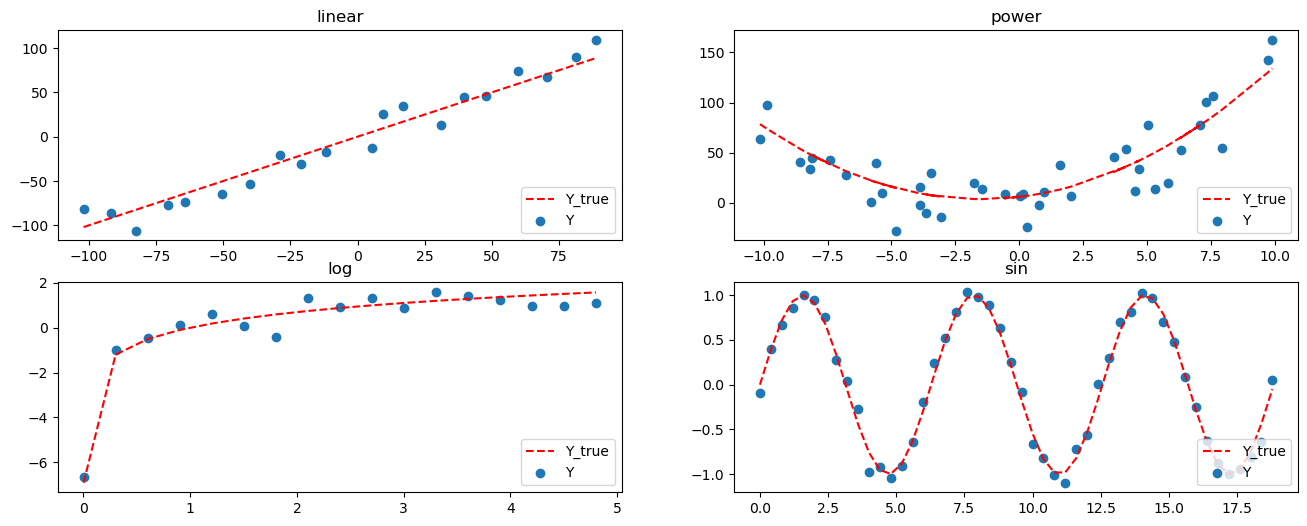

In [191]:
draw_utils.draw_plots(data, draw_data())

### Подготовка данных

In [192]:
prepare = DataPipeline('prepare_data')
#prepare.transform('X', 'X', data_utils.minmax_features)
#prepare.transform('Y', 'Y', data_utils.minmax_features)
#prepare.transform('Y_true', 'Y_true', data_utils.minmax_features)
prepare.transform('X', 'X', data_utils.normalize_features)
prepare.transform('Y', 'Y', data_utils.normalize_features)
prepare.transform('Y_true', 'Y_true', data_utils.normalize_features)
prepare.transform('X', 'X_prep', data_utils.prepare_features, poly="_poly")
prepare.transform('Y', 'Y_prep', data_utils.prepare_target)
prepare.transform('X_prep', 'W', linreg_utils.generate_weights)
prepare.apply(data[0])

In [193]:
data[0].val('X_prep').shape

(20, 2)

### Метрики

In [194]:
metrics = DataPipeline('metrics')
metrics.transform(['Y_prep', 'Y_pred'], 'MSE', linreg_utils.MSE, store_history=True)
metrics.transform(['Y_prep', 'Y_pred'], 'RMSE', linreg_utils.RMSE, store_history=True)
metrics.transform(['Y_prep', 'Y_pred'], 'MAPE', linreg_utils.MAPE, store_history=True)

### Метод наименьших квадратов

In [195]:
least_squares = DataPipeline('least_squares')
least_squares.transform(['X_prep', 'Y_prep'], 'W', linreg_utils.least_squares)
least_squares.transform(['X_prep', 'W'], 'Y_pred', linreg_utils.predict)

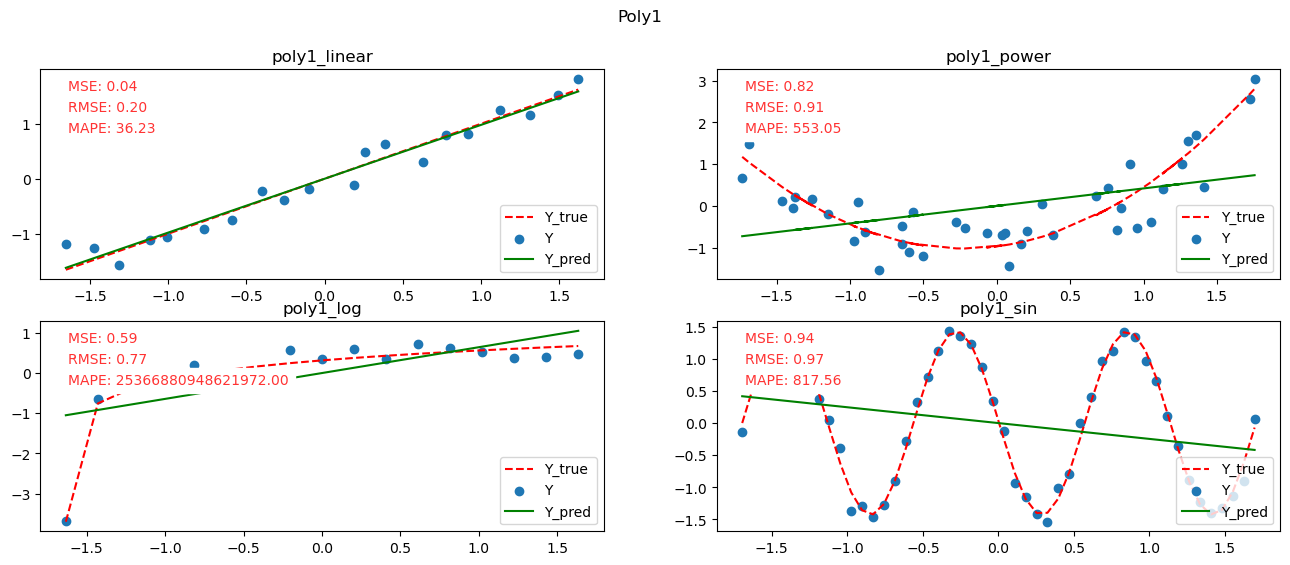

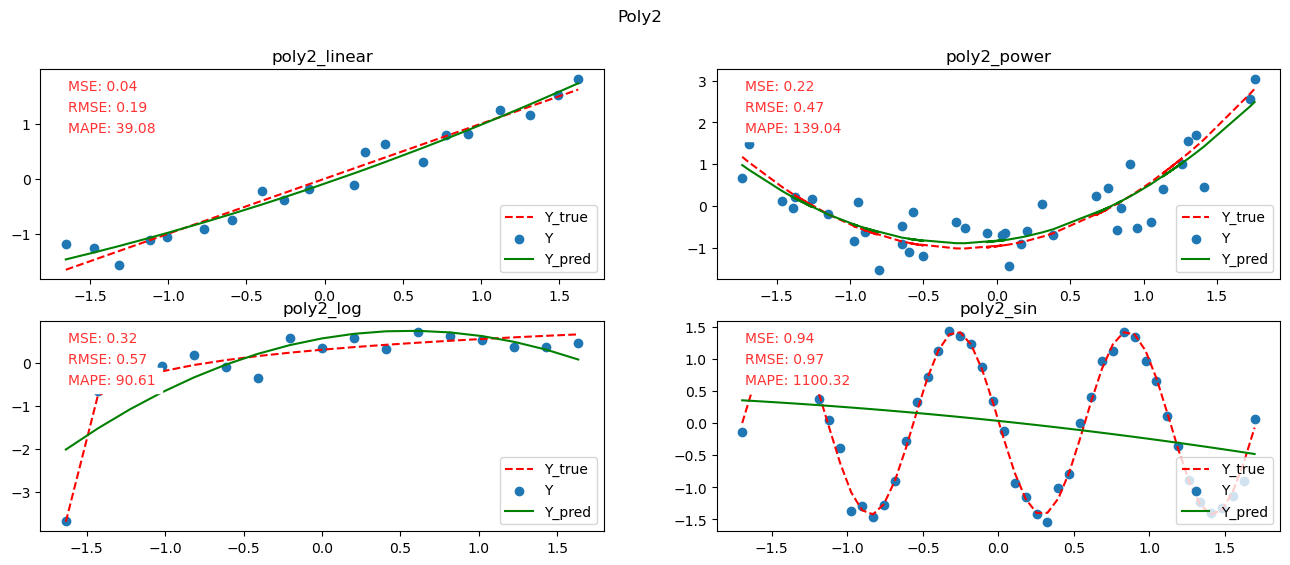

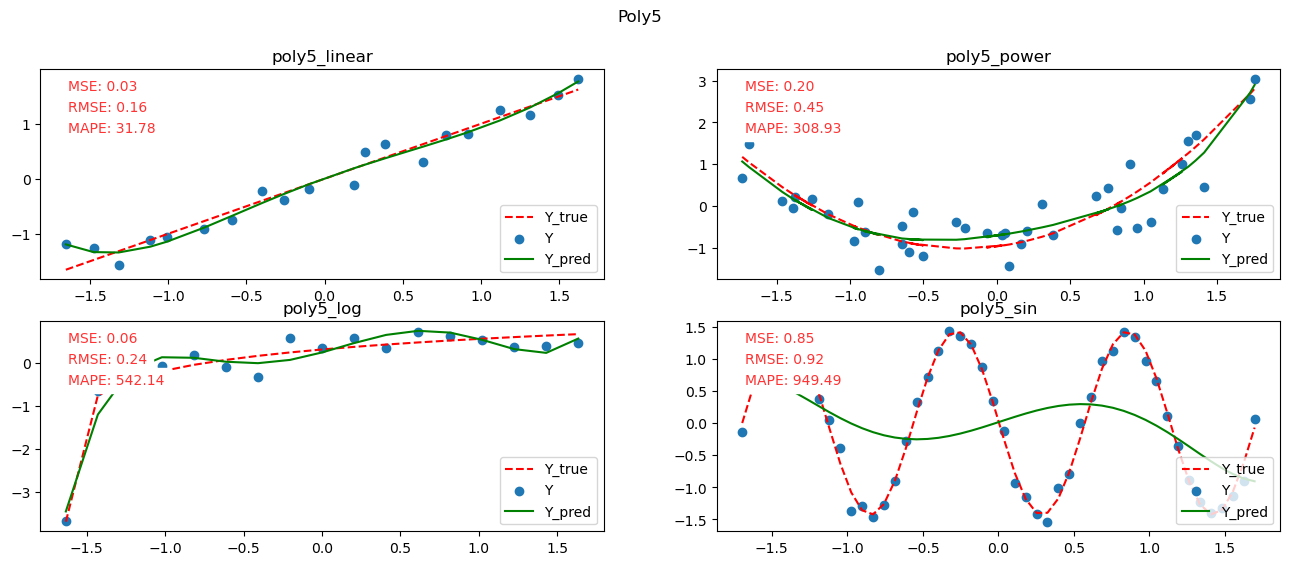

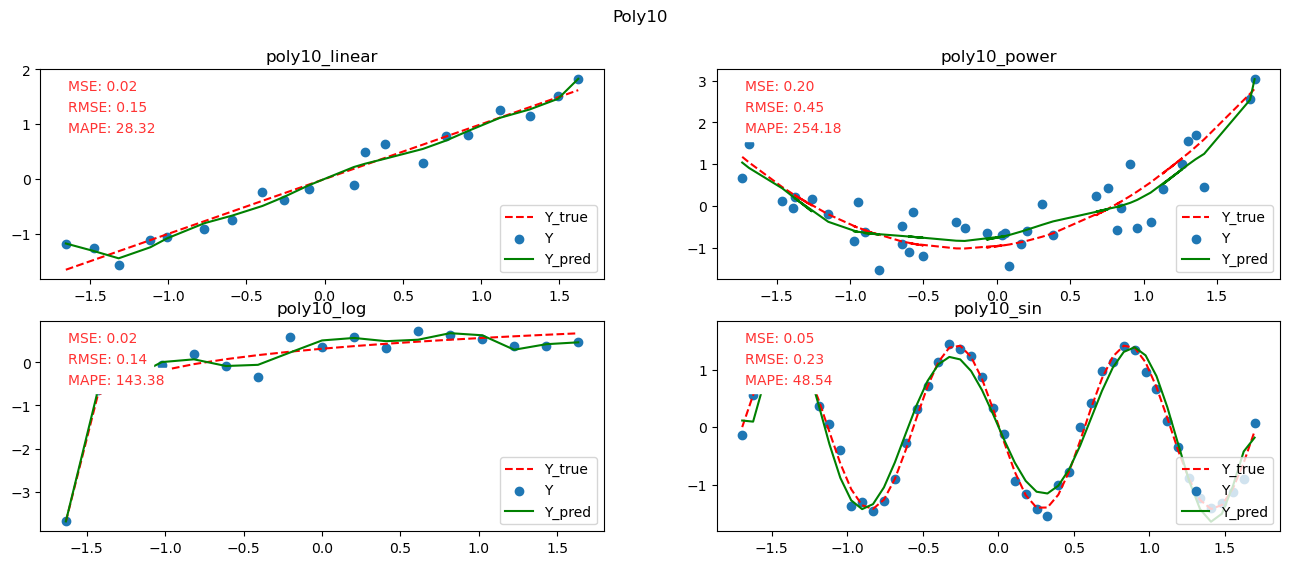

In [196]:
test_least_squares = DataPipeline.compose('test_least_squares', [prepare, least_squares, metrics])

for p in (1, 2, 5, 10):
    pipes = test_least_squares.apply(DataPipeline.copy_list(data, 'poly' + str(p), True), _poly=p)
    draw_utils.draw_plots(pipes, draw_data(['MSE', "RMSE", 'MAPE']), title='Poly'+str(p))

### Регуляризация

In [197]:
regularization = DataPipeline('regularization')
regularization.transform(['W'], 'grad_reg_loss', linreg_utils.grad_ridge_reg_loss, p_enable='_ridge_reg', l='_reg_l')
regularization.transform(['W'], 'grad_reg_loss', linreg_utils.grad_ridge_reg_loss, p_enable='_lasso_reg', l='_reg_l')
regularization.transform(['W', 'grad_reg_loss'], 'W', linreg_utils.update_weights, lr="_lr", p_enable='_reg')

### Градиентный спуск

In [198]:
gradient_descent_step = DataPipeline('gradient_step')
gradient_descent_step.transform(['X_prep', 'Y_prep', 'W'], 'grad_loss', linreg_utils.grad_loss)
gradient_descent_step.transform(['W', 'grad_loss'], 'W', linreg_utils.update_weights, lr="_lr")
gradient_descent_step.subpipeline(regularization)
gradient_descent_step.transform(['X_prep', 'W'], 'Y_pred', linreg_utils.predict)
gradient_descent_step.subpipeline(metrics)
test_gradient_descent = DataPipeline.compose('gradient_descent', [prepare, (gradient_descent_step, {'p_repeat':"_iterations"})])

### Градиентный спуск без регуляризации

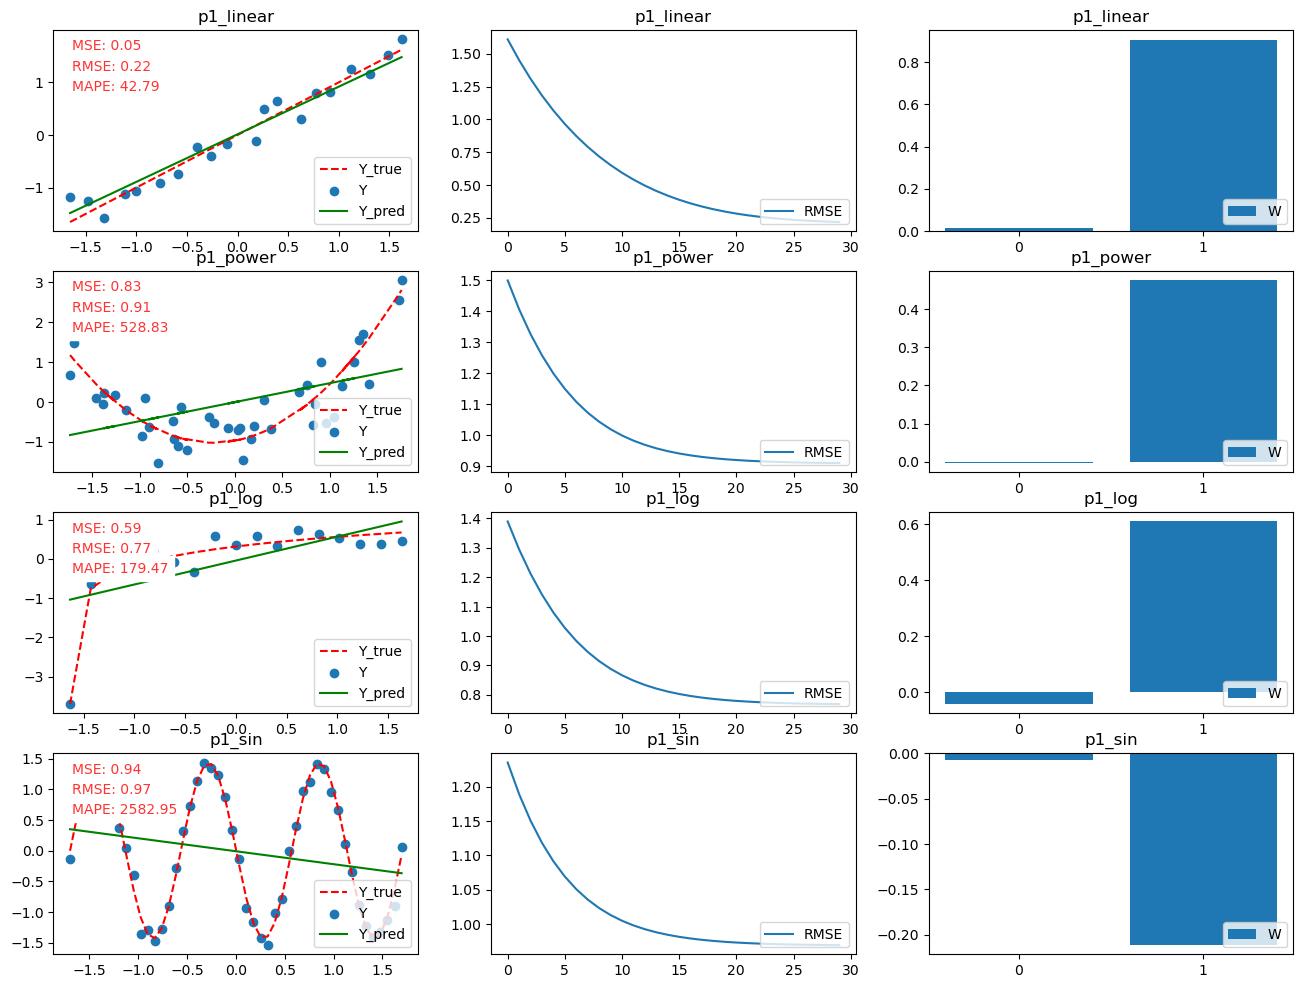

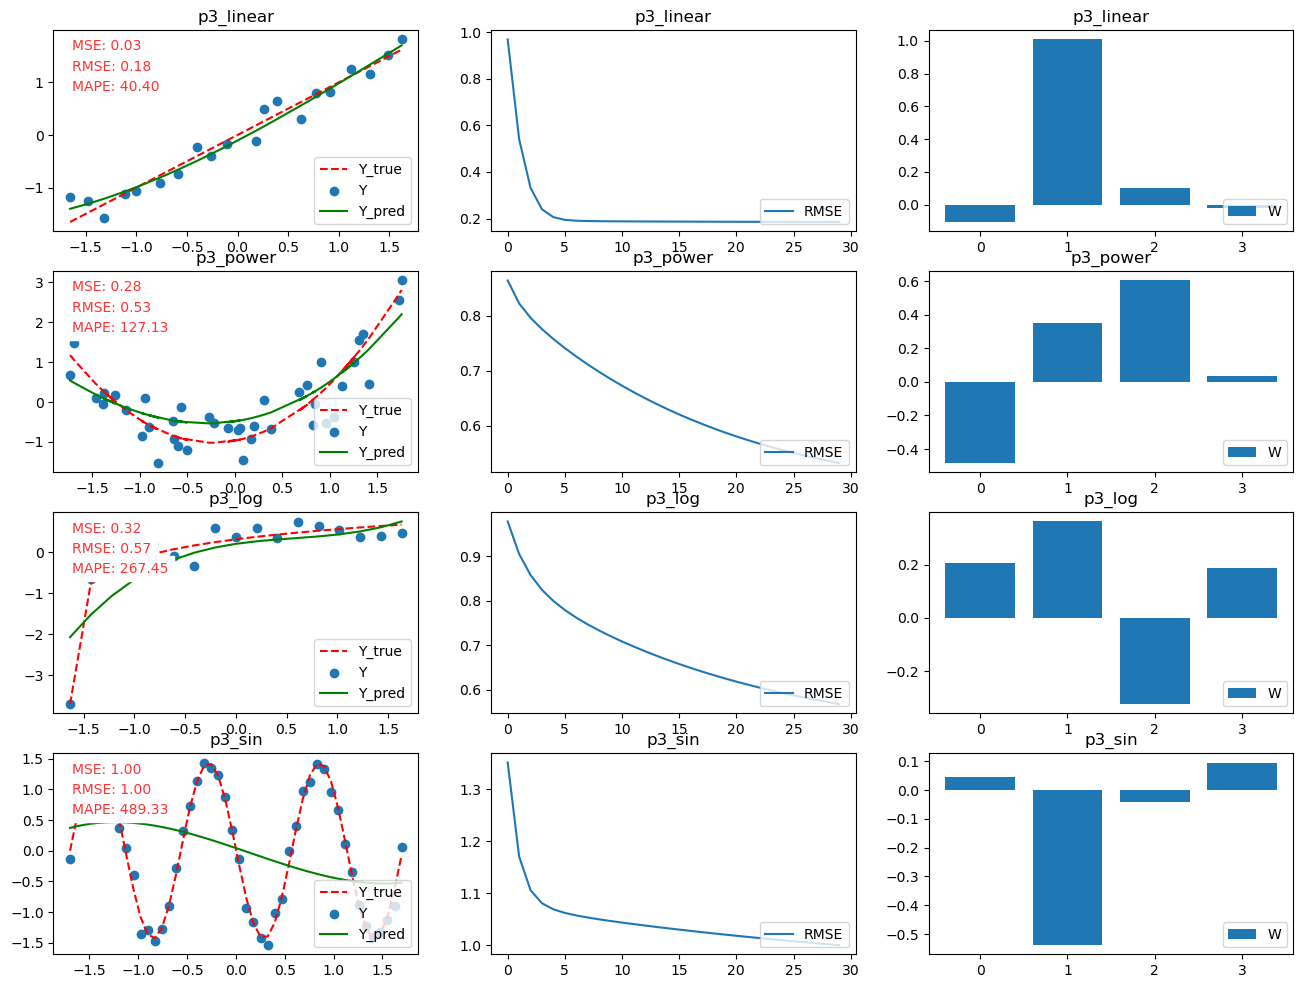

In [199]:
for p in (1, 3):
    pipes = test_gradient_descent.apply(DataPipeline.copy_list(data, "p" + str(p) , True), _lr=0.1, _iterations=30, _poly=p)
    draw_utils.draw_plots(pipes, [draw_data(['MSE', "RMSE", 'MAPE']), draw_utils.draw_metric(["RMSE"]), draw_utils.draw_compare_stats('W')], max_cols=3)

### Градиентный спуск с регуляризаций и без

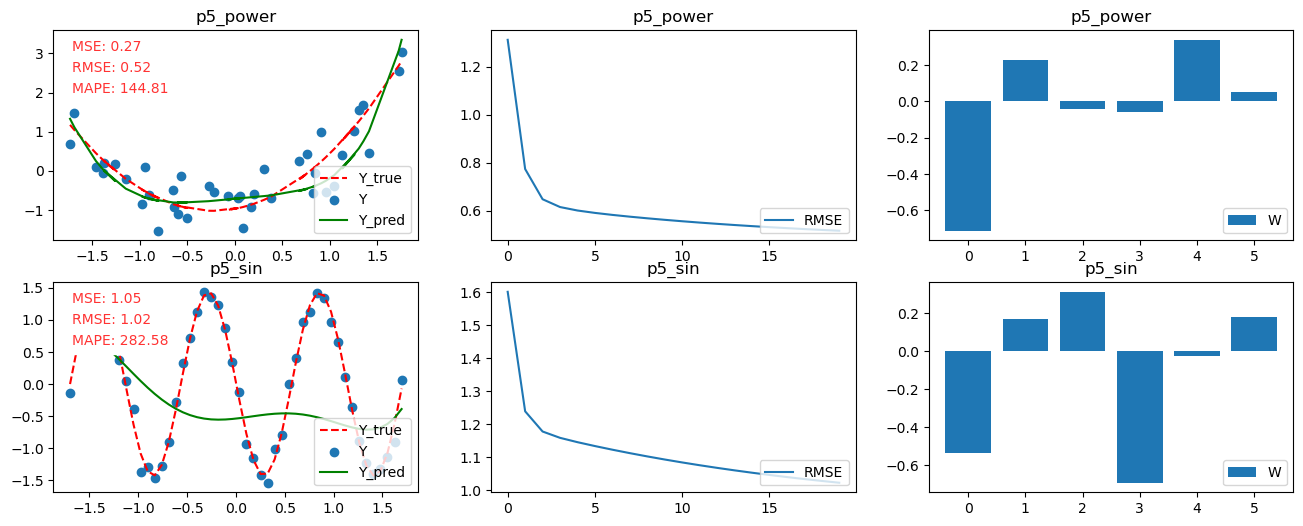

In [200]:
# берём параболу и синус
data_reg = DataPipeline.copy_list([data[1], data[3]], "p5" , True)
pipes = test_gradient_descent.apply(data_reg, _lr=0.05, _iterations=20, _poly=5)
draw_utils.draw_plots(pipes, [draw_data(['MSE', "RMSE", 'MAPE']), draw_utils.draw_metric(["RMSE"]), draw_utils.draw_compare_stats('W')], max_cols=3)

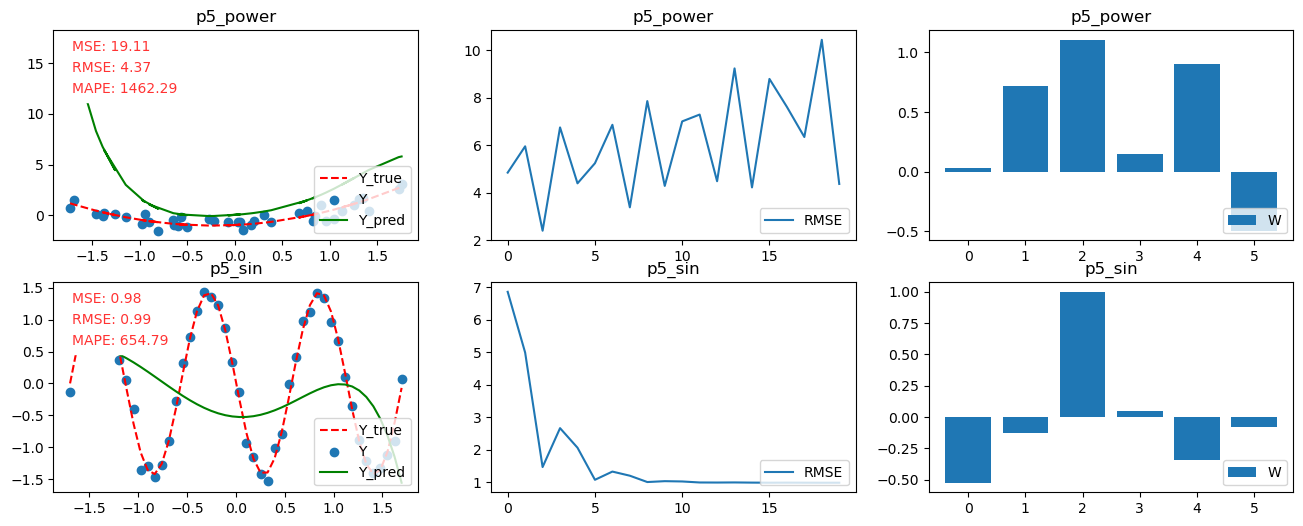

In [201]:
# берём параболу и синус
data_reg = DataPipeline.copy_list([data[1], data[3]], "p5" , True)
pipes = test_gradient_descent.apply(data_reg, _lr=0.05, _iterations=20, _poly=5, _reg=True, _ridge_reg=True, _lasso_reg=True, _reg_l=70)
draw_utils.draw_plots(pipes, [draw_data(['MSE', "RMSE", 'MAPE']), draw_utils.draw_metric(["RMSE"]), draw_utils.draw_compare_stats('W')], max_cols=3)